# Chapter 3: Classification
This chapter using the MNIST dataset, which consists of 70,000 small images of handwritten digits.

In [1]:
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
len(mnist['data'])

70000

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

784 represents 28x28 pixel images. Lets check out a single digit.

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]

# Reshape from 784 => 28x28
some_digit_image = some_digit.reshape(28,28)

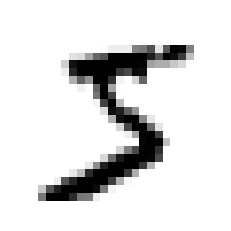

In [8]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [9]:
y[0]

'5'

The labels are currently strings; ML algorithms expect numbers. Let's convert them:

In [10]:
y = y.astype(np.uint8)

In [11]:
type(y[0])

numpy.uint8

Note: `uint8` is an unsigned integer between 0-255. 

## Creating a Test Set
The MNIST dataset comes preshuffled and split into training(0:60000) and test (60000:) sets.

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [13]:
y_train_5 = (y_train == 5) # Sets True for all 5s, otherwise False
y_test_5 = (y_test == 5)

 A good starting classifier is SGD (Stochastic Gradient Descent), using Scikit-Learn's `SGDClassifier` class. This classifier is good at handling large datasets efficiently, as it deals with training instances independently and one at a time. This makes it a good candidate for online learning.

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42) # Add for reproducible results
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

**Issue**
Issue arose regarding the shape of the input. The solution was reshaping the original `some_digit` to 1,-1 (1 x existing). The code below shows the different shapes and conversion.

In [24]:
some_digit.shape

(1, 784)

In [25]:
some_digit.reshape(1,-1).shape

(1, 784)

In [26]:
some_digit = some_digit.reshape(1,-1)

In [27]:
sgd_clf.predict(some_digit)

array([ True])

## Performance Measures
Evaluating a classifier is even trickier than evaluating a regressor. We'll explore a few different ways to do so.

### Using Cross-Validation

#### Aside: Custom Cross Validation Code
This can be used in place of Scikit-Learn's `cross_val_score()` for more customization.

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/Users/jwhudnall/Documents/github-code/hands-on-ML/env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604
